|Traitement|Scratch|VGG16|InceptionV3|Xception 
|-----|:-------:|:------:|:------:|:------ :
|Base|
|Avec Data Augmentation|
|Avec Data Augmentation et FineTuning|

# 1. Initialisation

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import VGG16
from keras.applications import InceptionV3
from keras.applications import ResNet50

In [ ]:
# Création des fonctions

def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model(act_function):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation=act_function))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def plot_activation_functions(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in activation_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in activation_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax[0].plot(val_loss_curves.leaky_relu, label='leaky_relu')
    ax[0].plot(val_loss_curves.relu, label='relu')
    ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
    ax[0].plot(val_loss_curves.tanh, label='tanh')
    ax[0].set_title('val_loss | ' + subtitle)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.leaky_relu, label='leaky_relu')
    ax[1].plot(val_acc_curves.relu, label='relu')
    ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
    ax[1].plot(val_acc_curves.tanh, label='tanh')
    ax[1].set_title('val_accuracy | ' + subtitle)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_activation_function.png',
                    transparent=True)
    return None


def plot_effect(history_std, history_modified, title, subtitle):
    # Conversion en dataframe
    df_model_std = pd.DataFrame(history_std.history['val_accuracy'], columns=["model_std"])
    df_model_modified = pd.DataFrame(history_modified.history['val_accuracy'], columns=[title])

    # Tracage
    pd.merge(df_model_std, df_model_modified, right_index=True, left_index=True).plot()
    plt.title(title + "_" + subtitle)
    plt.xlabel("epoch")
    plt.ylabel("val_accuracy")
    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '.png',
                transparent=True)
    plt.show()
    return None


def plot_result_fitting(history, subtitle, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + subtitle + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + subtitle + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    
    return None

# 2. Import des données et paramétrage
En phase exploratoire, je limite à 10% le nombre de races à tester (soit 12%)

In [3]:
n_breeds = 12
# Création du dataframe et sélection des 12 races les plus fournies en images
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")
dogs

Nous avons 12 races sélectionnées pour la phase d'expérimentation.


,uri,breeds
5084,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5085,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5086,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5087,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5088,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
...,...,...
15601,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
15602,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
15603,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
15604,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier


In [4]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

# Séparation des données d'entrainements et de validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

Optimisation des générateurs :
* Pour des raisons d'économies de calcul, je réduis toutes les images à 150*150 pixels,
* Il est important que batch_size soit un nombre entier du jeu de test. Si ce n'est pas le cas du jeu d'entrainement et du jeu de validation, ce n'est pas bien grave car l'image sera retraitée dans une autre epoch,
* shuffle sera égal à True sur les jeu d'entraînement et de validation, et sera égal à False sur le jeu de test. Cela me permettra de faire correspondre les prédictions en sortie avec les identifiants.
* L'augmentation des données ne se fera que sur les données d'entraînements. Cela consiste à modifier une image de manière aléatoire (rotation, zoom, mirroir) de manière à ce que l'algorithmes ne voit qu'une fois la même image.


In [5]:
### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Sans augmentation des données
train_gen = train_datagen.flow_from_dataframe(
                  train,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=train_batch_size,
                  seed=seed
                  )


# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


# 3. Evaluation du modèle InceptionV3
## 3.1 Paramétrage

In [26]:
conv_base

In [24]:
### Paramétrage de la configuration
# Titre documents de sortie
subtitle = "InceptionV3"

# Choix du modèle convolutionnel de base, avec gel de la base
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

Nombre de poids entraînable avant gel de la base convolutionnelle : 188
Nombre de poids entraînable après gel de la base convolutionnelle : 0


## 3-3. Choix des ajustements
### 3-3-1. Formation du modèle standard comme point de comparaison

In [28]:
def plot_result_fitting(history, subtitle, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + subtitle + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + subtitle + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)

Epoch 1/40
77/77 [==============================] - 10s 126ms/step - loss: 5.9285 - accuracy: 0.6417 - val_loss: 1.5481 - val_accuracy: 0.7217
Epoch 2/40
77/77 [==============================] - 9s 112ms/step - loss: 0.7050 - accuracy: 0.8312 - val_loss: 0.7563 - val_accuracy: 0.7925
Epoch 3/40
77/77 [==============================] - 9s 117ms/step - loss: 0.2278 - accuracy: 0.9250 - val_loss: 0.7908 - val_accuracy: 0.7901
Epoch 4/40
77/77 [==============================] - 9s 114ms/step - loss: 0.1248 - accuracy: 0.9587 - val_loss: 0.9080 - val_accuracy: 0.7854
Epoch 5/40
77/77 [==============================] - 9s 111ms/step - loss: 0.0975 - accuracy: 0.9610 - val_loss: 1.1157 - val_accuracy: 0.7642
Epoch 6/40
77/77 [==============================] - 9s 111ms/step - loss: 0.0856 - accuracy: 0.9728 - val_loss: 0.9558 - val_accuracy: 0.8090
Epoch 7/40
77/77 [==============================] - 10s 124ms/step - loss: 0.0249 - accuracy: 0.9906 - val_loss: 0.8916 - val_accuracy: 0.8184
Epoc

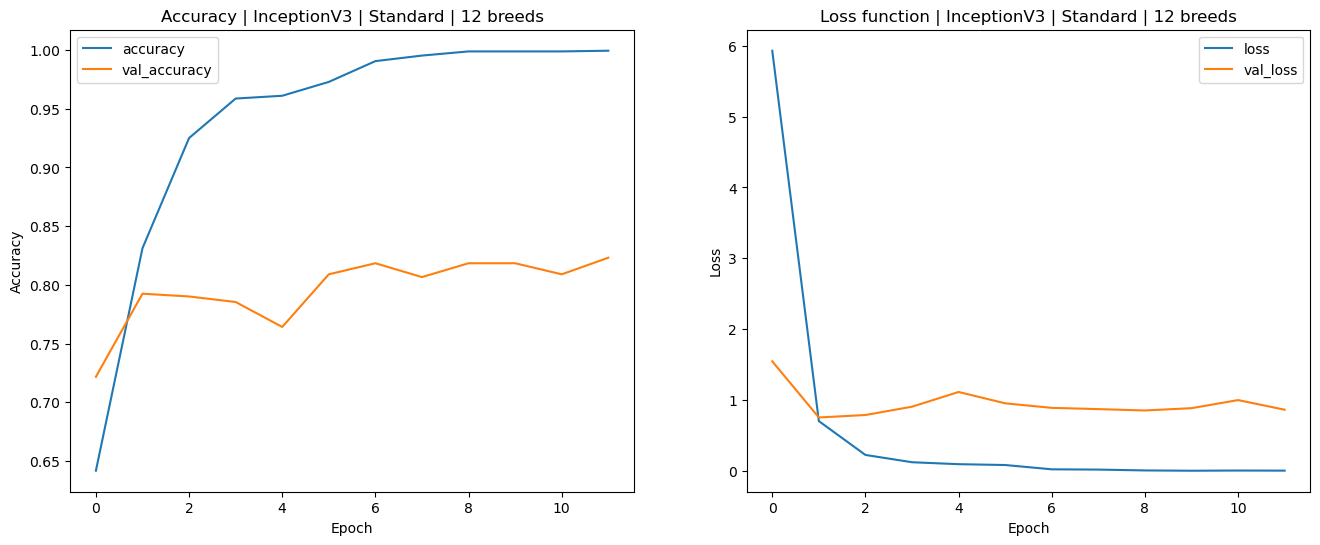

In [30]:
epochs = 40
verbose = 1
early_stopping_monitor = EarlyStopping(patience=10)

model_std = get_model(act_function='relu')
model_std.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_std = model_std.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "Standard"
plot_result_fitting(history_std, subtitle, title, n_breeds)


### 3-3-2. Mesure de l'effet Data Augmentation

Epoch 1/40
77/77 [==============================] - 19s 241ms/step - loss: 4.8412 - accuracy: 0.5189 - val_loss: 0.9394 - val_accuracy: 0.7052
Epoch 2/40
77/77 [==============================] - 18s 231ms/step - loss: 1.1206 - accuracy: 0.6452 - val_loss: 0.6928 - val_accuracy: 0.7476
Epoch 3/40
77/77 [==============================] - 18s 229ms/step - loss: 0.9462 - accuracy: 0.6789 - val_loss: 0.5724 - val_accuracy: 0.8019
Epoch 4/40
77/77 [==============================] - 17s 220ms/step - loss: 0.9519 - accuracy: 0.6978 - val_loss: 0.6367 - val_accuracy: 0.7854
Epoch 5/40
77/77 [==============================] - 18s 233ms/step - loss: 0.9696 - accuracy: 0.6806 - val_loss: 0.6538 - val_accuracy: 0.7736
Epoch 6/40
77/77 [==============================] - 17s 222ms/step - loss: 0.8375 - accuracy: 0.7202 - val_loss: 0.6197 - val_accuracy: 0.8066
Epoch 7/40
77/77 [==============================] - 17s 226ms/step - loss: 0.7809 - accuracy: 0.7544 - val_loss: 0.6555 - val_accuracy: 0.7830

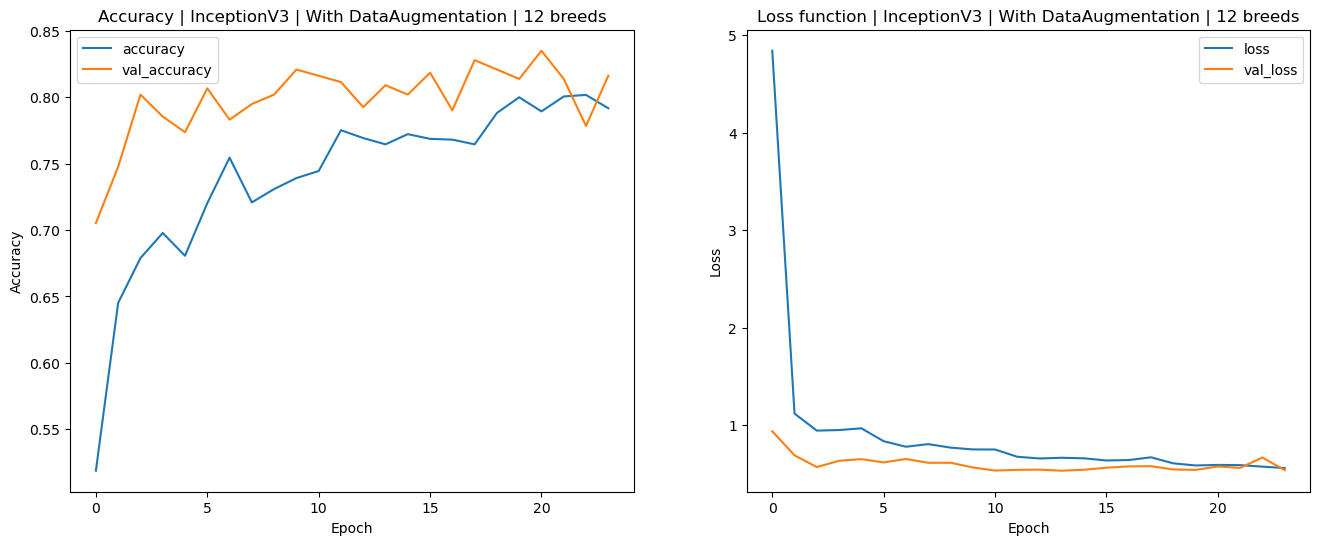

In [31]:
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "With DataAugmentation"

plot_result_fitting(history_modified, subtitle, title, n_breeds)

### 3-3-4. Mesure de l'effet Fine Tuning
Pour mesurer cela, je dégèle la dernière couche de l'algorithme pour entraînement.

In [33]:
for layer in conv_base.layers:
   print(layer.name)

input_7
conv2d_376
batch_normalization_377
activation_376
conv2d_377
batch_normalization_378
activation_377
conv2d_378
batch_normalization_379
activation_378
max_pooling2d_16
conv2d_379
batch_normalization_380
activation_379
conv2d_380
batch_normalization_381
activation_380
max_pooling2d_17
conv2d_384
batch_normalization_385
activation_384
conv2d_382
conv2d_385
batch_normalization_383
batch_normalization_386
activation_382
activation_385
average_pooling2d_36
conv2d_381
conv2d_383
conv2d_386
conv2d_387
batch_normalization_382
batch_normalization_384
batch_normalization_387
batch_normalization_388
activation_381
activation_383
activation_386
activation_387
mixed0
conv2d_391
batch_normalization_392
activation_391
conv2d_389
conv2d_392
batch_normalization_390
batch_normalization_393
activation_389
activation_392
average_pooling2d_37
conv2d_388
conv2d_390
conv2d_393
conv2d_394
batch_normalization_389
batch_normalization_391
batch_normalization_394
batch_normalization_395
activation_388
acti

Rappel du nombre de poids entraînable avant gel de la base convolutionnelle : 188
Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle : 12
Epoch 1/40
77/77 [==============================] - 19s 250ms/step - loss: 2.0020 - accuracy: 0.5531 - val_loss: 0.7703 - val_accuracy: 0.7736
Epoch 2/40
77/77 [==============================] - 19s 246ms/step - loss: 0.9002 - accuracy: 0.7102 - val_loss: 0.5841 - val_accuracy: 0.8231
Epoch 3/40
77/77 [==============================] - 17s 225ms/step - loss: 0.8135 - accuracy: 0.7220 - val_loss: 0.6046 - val_accuracy: 0.8113
Epoch 4/40
77/77 [==============================] - 18s 230ms/step - loss: 0.7509 - accuracy: 0.7391 - val_loss: 0.6211 - val_accuracy: 0.8066
Epoch 5/40
77/77 [==============================] - 18s 234ms/step - loss: 0.7250 - accuracy: 0.7497 - val_loss: 0.6056 - val_accuracy: 0.8113
Epoch 6/40
77/77 [==============================] - 18s 231ms/step - loss: 0.6270 - accuracy: 0.7851 - val_loss: 0

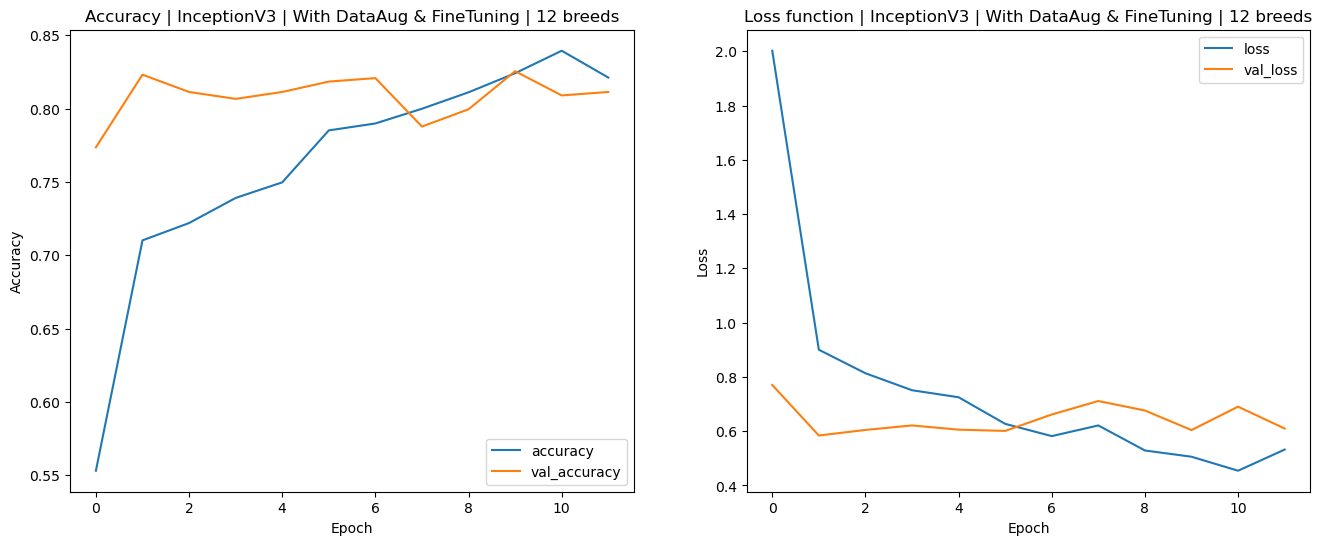

In [40]:
# Avec fine tuning
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Rappel du nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))

for layer in conv_base.layers[:-24]:
    layer.trainable = False
for layer in conv_base.layers[-24:]:
    layer.trainable = True
        
print('Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle :', len(conv_base.trainable_weights))

# Avec fine tuning
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "With DataAug & FineTuning"

plot_result_fitting(history_modified, subtitle, title, n_breeds)

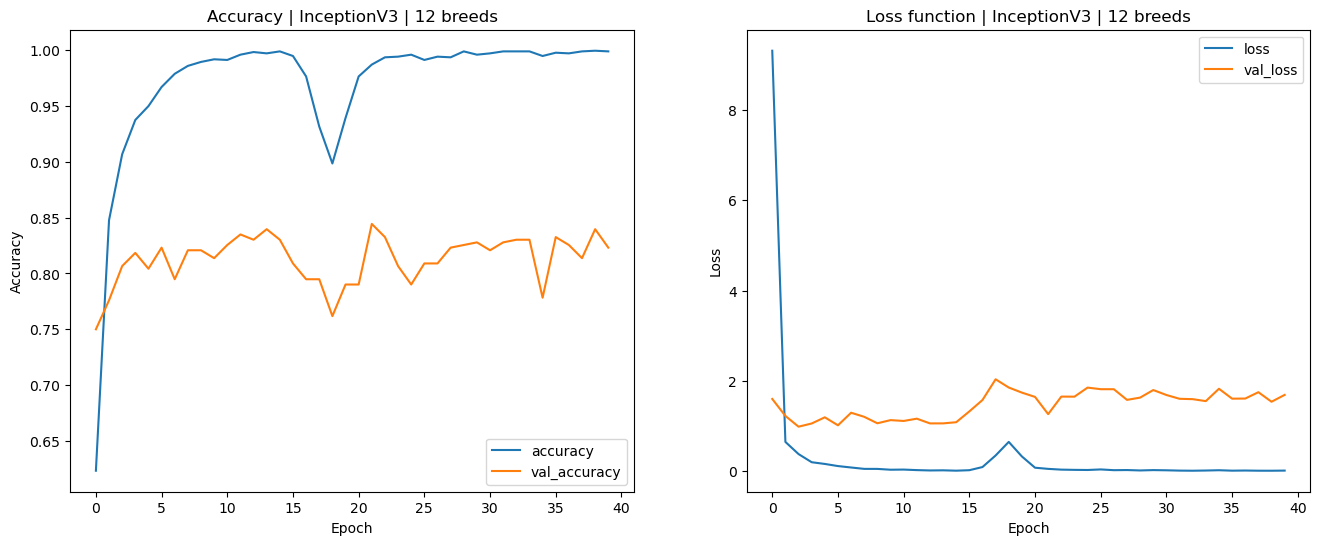

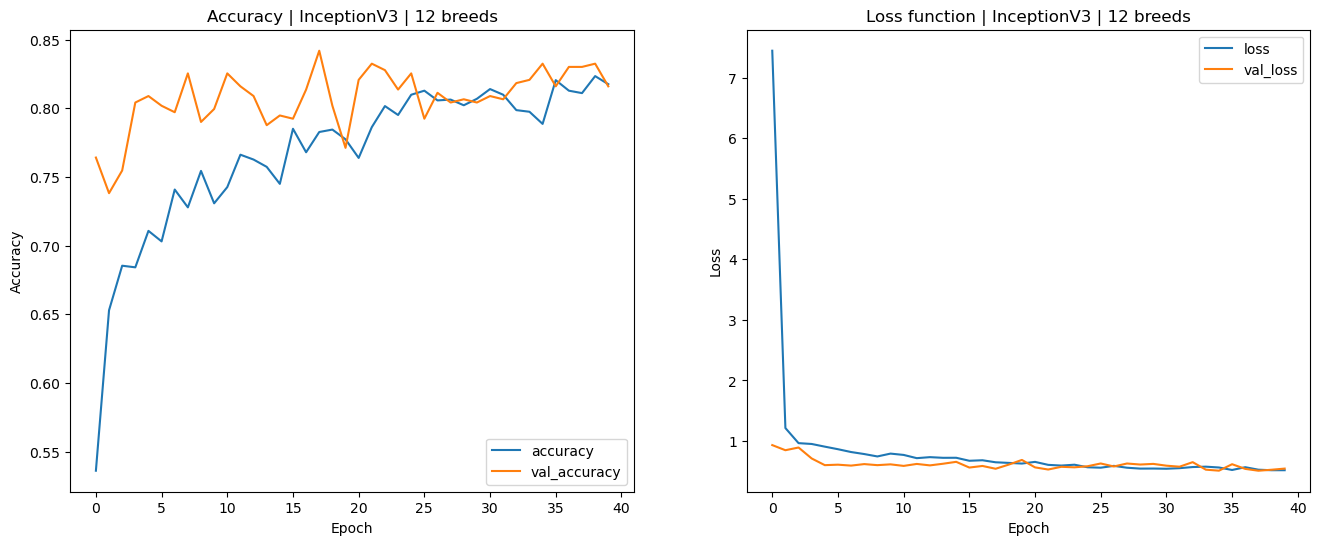

In [20]:
plot_result_fitting(history_std, subtitle, n_breeds)
plot_result_fitting(history_modified, subtitle, n_breeds)

In [23]:
model_modified.evaluate(test_gen)

53/53 [==============================] - 2s 41ms/step - loss: 0.6467 - accuracy: 0.7981


[0.6467474102973938, 0.798113226890564]

### 3-3-5. Conclusion sur les différentes mesures
* La data augmentation augmente les performance du modèle mais le rend légèrement moins stable
* Batch normalization dégrade le modèle
* Dropout avec une valeur de 0.2 maintient le modèle, mais diminue sa stabilité, Dropout avec une valeur de 0.5 dégrade le modèle et le rend instable.
* Contre mon attente, le fine tuning dégrade fortement le modèle, peut-être il y a un problème ?

## 3-4. Evaluation

In [41]:
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

# Résumé du modèle
model_final.summary()

Nombre de poids entraînable avant gel de la base convolutionnelle : 188
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_18 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dense_36 (Dense)             (None, 12)                3084      
Total params: 26,524,716
Trainable params: 4,721,932
Non-trainable params: 21,802,784
_________________________________________________________________


----

In [42]:
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])
title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

Epoch 1/500
77/77 [==============================] - 20s 262ms/step - loss: 7.1301 - accuracy: 0.5366 - val_loss: 1.1790 - val_accuracy: 0.7453
Epoch 2/500
77/77 [==============================] - 19s 250ms/step - loss: 1.4712 - accuracy: 0.6322 - val_loss: 0.9936 - val_accuracy: 0.7099
Epoch 3/500
77/77 [==============================] - 18s 235ms/step - loss: 1.0089 - accuracy: 0.6606 - val_loss: 0.6537 - val_accuracy: 0.7901
Epoch 4/500
77/77 [==============================] - 18s 232ms/step - loss: 0.9140 - accuracy: 0.6930 - val_loss: 0.6685 - val_accuracy: 0.7689
Epoch 5/500
77/77 [==============================] - 19s 247ms/step - loss: 0.9239 - accuracy: 0.6860 - val_loss: 0.7281 - val_accuracy: 0.7642
Epoch 6/500
77/77 [==============================] - 17s 225ms/step - loss: 0.8610 - accuracy: 0.7155 - val_loss: 0.8048 - val_accuracy: 0.7264
Epoch 7/500
77/77 [==============================] - 18s 238ms/step - loss: 0.8230 - accuracy: 0.7184 - val_loss: 0.6257 - val_accuracy:

TypeError: plot_result_fitting() missing 1 required positional argument: 'n_breeds'

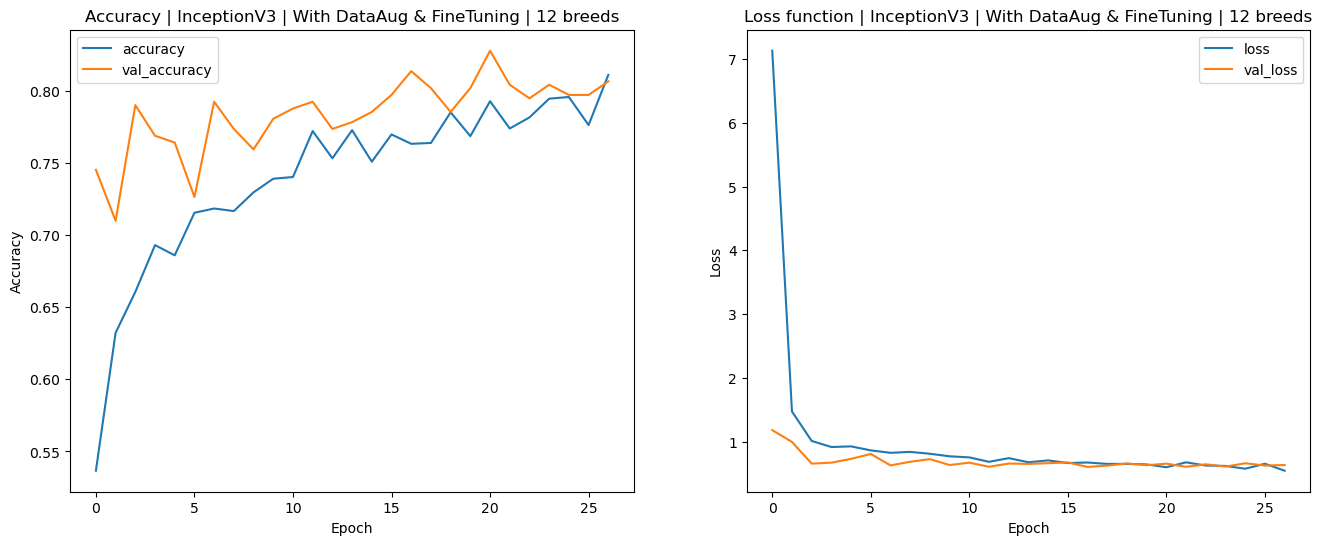

In [43]:
plot_result_fitting(history, subtitle, title, n_breeds)

In [ ]:
model_final.evaluate(test_gen)

# 4. Evaluation du modèle avec 60 races (50 %)

In [45]:
n_breeds = 60
# Création du dataframe avec 50 races
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la montée en charge.")

# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])

title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

model_final.evaluate(test_gen)

Nous avons 120 races sélectionnées pour la montée en charge.
Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
Nombre de poids entraînable avant gel de la base convolutionnelle : 188
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Epoch 1/500
 1913/13171 [===>..........................] - ETA: 3:33 - loss: 5.8916 - accuracy: 0.0141

KeyboardInterrupt: 